In [3]:
#importing necessary libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
#importing the file
df=pd.read_csv("amazon_alexa.tsv",sep="\t")       #As it is a tab separted file
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [5]:
#To check the sentiment from the obtained rating
def sentiments(df):
    if df['rating']>3.0:
        return 'Positive'
    elif df['rating']<=3.0:
        return 'Negative'
df['sentiment']=df.apply(sentiments,axis=1)

In [6]:
df.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [7]:
#checking null values
data_v1=df[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

# Data_Cleaning

In [20]:
def cleaning(df,stop_words):
    df['verified_reviews']=df['verified_reviews'].apply(lambda x:" ".join(x.lower()for x in x.split()))
    df['verified_reviews']=df['verified_reviews'].str.replace("d",'')
    df['verified_reviews']=df['verified_reviews'].apply(lambda x:" ".join(x for x in x.split()if x not in stop_words))
    df['verified_reviews']=df['verified_reviews'].apply(lambda x:" ".join([Word(x).lemmatize()for x in x.split()]))
    return df

In [21]:
stop_words=stopwords.words("english")

In [22]:
data_v1=cleaning(data_v1,stop_words)

In [23]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


In [24]:
common_words=" "
for i in data_v1.verified_reviews:
    i=str(i)
    tokens=i.split()
    common_words+=" ".join(tokens)+" "

In [25]:
common_words

' love echo! love it! sometimes playing game, answer question correctly alexa say got wrong answer you. like able turn light away home. ha lot fun thing. 4 yr ol learns inosaurs, control light play game like categories. nice soun playing music well. music receive echo gift. neee another bluetooth something play music easily accessible, foun smart speaker. can’t wait see else o. without cellphone, cannot use many features. ipa see use. great alarm. u r almost eaf, hear alarm beroom living room, reason enough keep her.it fun ask ranom question hear response. oes seem smartbon politics yet. think 5th one i\'ve purchase. i\'m working getting one every room house. really like feature offer specifily playing music echo controlling light throughout house. look great love it! i’ve listene song haven’t hear since chilhoo! get news, weather, information! it’s great! sent 85 year ol a, talk constantly. love it! learning knew thing eveyay! still figuring everything work far easy use unerstan. oes 

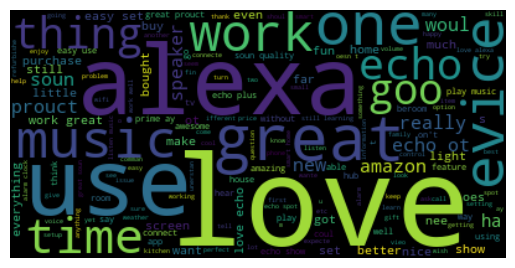

In [26]:
#visualizing the most frequent words
word_cloud=wordcloud.WordCloud().generate(common_words)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
le=LabelEncoder()
data_v1['sentiment']=le.fit_transform(data_v1['sentiment'])
data_v1.head()

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1


In [28]:
tokenizer=Tokenizer(num_words=500,split=" ")
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)

In [29]:
x=tokenizer.texts_to_sequences(df['verified_reviews'].values)
x=pad_sequences(x)
x

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ..., 263, 276,  24],
       ...,
       [  0,   0,   0, ...,  89, 326,  32],
       [  0,   0,   0, ..., 217,  58, 290],
       [  0,   0,   0, ...,   0,   0,   0]])

In [47]:
model=Sequential()
model.add(Embedding(500,120,input_length=x.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 319, 120)          60000     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 319, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 176)               209088    
                                                                 
 dense_1 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
y=pd.get_dummies(data_v1['sentiment'])
y.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [49]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [50]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [51]:
batch=32
model.fit(x_train,y_train,epochs=5,batch_size=batch,verbose=1)

Epoch 1/5
69/69 [==============================] - 284s 4s/step - loss: 0.3911 - accuracy: 0.8739
Epoch 2/5
69/69 [==============================] - 258s 4s/step - loss: 0.3124 - accuracy: 0.8812
Epoch 3/5
69/69 [==============================] - 262s 4s/step - loss: 0.2378 - accuracy: 0.9079
Epoch 4/5
69/69 [==============================] - 273s 4s/step - loss: 0.2061 - accuracy: 0.9224
Epoch 5/5
69/69 [==============================] - 257s 4s/step - loss: 0.1922 - accuracy: 0.9229


In [52]:
model.evaluate(x_test,y_test)

30/30 [==============================] - 18s 550ms/step - loss: 0.2648 - accuracy: 0.8836


[0.2648356854915619, 0.8835979104042053]